<div align="center"><span style = "font-size:250%;">MINI PROJECT 1</span></div> 
<div align="center"><span style = "font-size:150%;">HADOOP ECOSYSTEM</span></div>

# Data Analysis

## This experiment was done on the first 1M samples

Extracted using the following code 
```python
import bz2
import json
n = 1000000
with open("sample_input_1M.txt", "w") as file_out:
    with bz2.BZ2File("RC_2015-01.bz2","rb") as f:
        file_out.write("\n".join([f.readline().decode().strip() for _ in range(n)]))
```

### Read the output file to perform some visualizations on it

In [2]:
f = open("part-00000", "r")
Lines = f.readlines() 


In [3]:
upvotes = []
topics = []
sentiment = []
contr = []

for line in Lines: 
    key, value = line.strip().split("\t")
    value = eval(value)
    
    *key, case = key.split(":")
    key = ":".join(key) # handle the case where key has a :

    if case == "upvotes":
        if value > 100:
            upvotes.append((key, value))
    elif case == "topics":
        topics.append((key, value))

    elif case == "sent":
        sentiment.append((key, value))

    else:
        contr.append((key,value))


## Analysis on the % of positive comments per subreddit.

In the diagram below, we can observe that the percentage of positive comments for the topic 2019 was close to 0%, while 2009 yielded positive comments with a percentage higher than 80. Also, 2014 and 2015 yielded percentages between 40% and 50% which is closer to having negative comments about those years than positive ones. It seems like that there is a trend that past years are better than the newer ones. 

Transferring the focus to more general topics that do not involve the year, we have topics like "2spookyforme" and "29october" with very high percentage of positive comments. (It seems like people think nicely of Halloween).

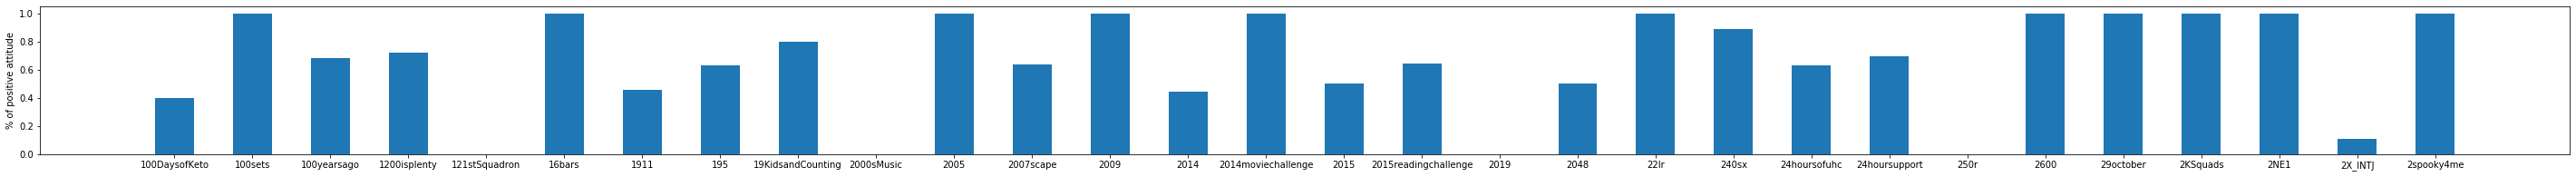

In [65]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(50, 3))  
plt.bar(*zip(*sentiment[0:30]), width = 0.5)
plt.ylabel('% of positive attitude')
plt.show()

## Analysis on the topics with highest upvotes

In this analysis, we sorted the topics based on the upvotes count in descending order. We then discarded the highest 300 words since they were mainly not topics but rather stopwords that were msised from the NLTK stopword library. 

Plotting the highest upvotes starting the 300th entry, we see a few words that seem to be adequate topics and a few others that seem like stopwords that were not extracted accurately by the mapper. Words like "war", "song", "wish", "laugh" are all topics that seem to have a huge upvote count. Other words that were mistaken for being topics were "couldnt", "yet" and "ago". Another interesting observation is the word "eye". This word could be interpreted as the eye of the human body, and could be interpreted as an onomatopoeia like the words "meow", "roar" and other phonetically spelled words that just represent sounds. 

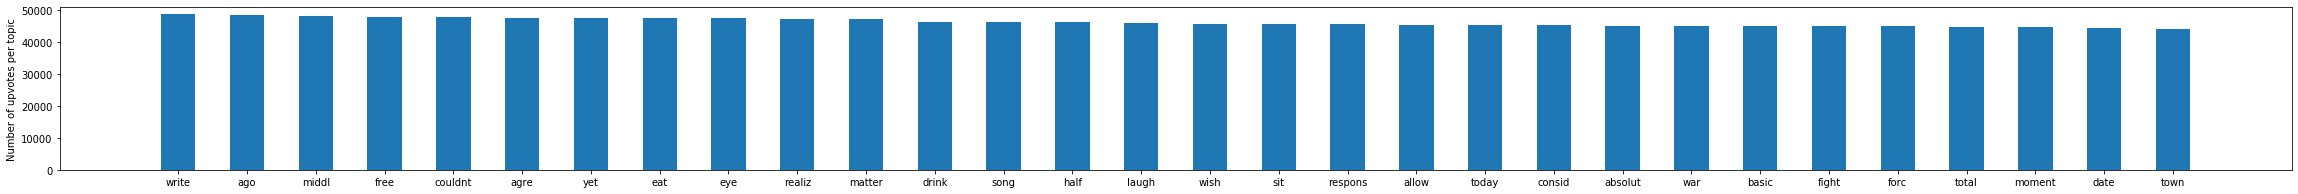

In [73]:
# Sort topics based on upvote count
upvotes.sort(key=lambda x:x[1], reverse = True)

plt.figure(figsize=(40, 3))  
plt.bar(*zip(*upvotes[300:330]), width = 0.5)
plt.ylabel('Number of upvotes per topic')
plt.show()

## Analysis on the most discussed topics per subreddit
We can see a sample of results below with the the most discussed topics. For instance, we can observe from the topic "100DaysofKeto" that the most discussed topics is the keto diet and most surprisingly, pizza. We can also observe subreddits that relate to the human psychology like "depression" include topics about human emotion like "feel" and "im" to refer to the person's enternal conflicts when associated with depression. Other more general subreddits like "asktrp" do not include specific topics but rather have more stopwords that were detected as "most discussed topics". Words like "dont", "get", "like" are all not indicative. It seems that general topics have a wide range of audience with lots of diverse conversations that only stopwords get picked up rather than adequate topics. 

In [25]:
print("Subreddit Name                     Most discussed topics\n")

for subreddit, most_discussed in topics[0::1000]:
    print("{:<34}{}".format(subreddit, most_discussed))

Subreddit Name                     Most discussed topics

100DaysofKeto                     [('day', 3), ('keto', 3), ('go', 3), ('new', 3), ('pizza', 3)]
CelebrityNipples                  [('naughti', 2), ('well', 2), ('toward', 1), ('balanc', 1), ('good', 1)]
FuckYouImAShark                   [('get', 1), ('tattoo', 1), ('would', 1), ('ever', 1)]
LonghornNation                    [('get', 10), ('offens', 8), ('think', 6), ('watson', 6), ('dont', 6)]
Proasheck                         [('like', 3), ('im', 3), ('die', 2), ('year', 2), ('upload', 2)]
TheEricAndreShow                  [('hannib', 1), ('buress', 1), ('support', 1), ('geobullshit', 1), ('brit', 1)]
asktrp                            [('dont', 74), ('get', 74), ('go', 60), ('like', 53), ('time', 50)]
depression                        [('im', 337), ('feel', 296), ('dont', 294), ('year', 283), ('know', 273)]
hiphop101                         [('hiphop', 3), ('get', 2), ('start', 2), ('listen', 2), ('oddise', 1)]
neckbeardarmy  

# Challenges faced and optimizations

Our first challenge was to take up a chunk of the data without decoding all of it, we knew that Bzip2 is splittable, so we searched for a unix command to extract chunks from i, but we were not succesful. However, when we looked in the python standard modules we found a bz2 module that did what we need exactly. We can open the file like a normal file  and have an iterator over it, since the iterator reads line by line we do not have to worry about memory limits, so we made a small script to extract the number of lines we wanted and we never actually extracted the whole bz2 at all.

One of the main challenges faced was using the NLTK library in the DFS without downloading it. We used `pip` to install the library and all its dependency in a local folder for the project. Secondly, we tried adding the NLTK folder zipped in .zip format and then called the .py modules from the zipped files using ZipImport built-in library in python which is automatizally used when we add a .zip file in `sys.path`. However, regex library contained .so files (dynamic libraries) that weren't being imported normally and we got importerror exceptions.

After searching for the reason and reading the python docs, we realized that python does not allow importing dynamic modules (.so files) from zipped folders as explained [here](https://docs.python.org/3/library/zipimport.html). Then we tried to find a way to include the whole modules libraries folder in the job, for that we looked in the hadoop docs and the lectures and we found that we can pass `-archives` to the streaming job that takes `.tar` or `.tgz` files. Thus, we compressed the NLTK folder using tar.gz. That way, no libraries needed downloading, and all the necessary modules could be imported from inside the DFS. And we did that same for the `nltk_data` folder that is needed for stemming and stopwords.

Furthermore, several unforseen errors have risen once we started running the code on a larger chunk of the dataset. We found that there are certain entries wherein the body has no white spaces and so the PorterStemmer in the NLTK module crashed trying to step a word that is too long. To solve this issue, we added a condition on the word length to not exceed 46 letters which is longer than the longest technical word in the english language. 

When in early testing on 100k samples, we noticed that controversiality is always 0, so we were curious and investigated the issue to find out that it is always 0 in the whole data set more on that later in the report.

Another optimization we tackled to fit a larger portion of the dataset was to split the subreddit name based on the last semicolon found. This is because we concatinate the subreddit name with the task that this subreddit serves. For instance, if the task is upvotes count, the key would be "{word}:upvotes". Splitting the key on ":" broke our code when the word had a comma embedded in the string. 

# Final code design

We decided to make just one job, to make the cimputation straightforward and to avoid copying output files between jobs.

However, in mappper and reducer we sectioned the code and added tags at the end of each key to distinguish what is running. 

First let's analyze the mappper
1. Setting up
    ```python
    #!/usr/bin/python3

    import sys
    import json
    import re
    import os

    sys.path.insert(0, 'nltk')
    from nltk.tokenize import word_tokenize
    from nltk.corpus import stopwords
    from nltk.stem.porter import PorterStemmer
    import nltk
    import math

    nltk.data.path.insert(0, "nltk_data") # Make NTLK look in the current path on folder nltk_data

    stopwords_english = stopwords.words('english')
    stemmer = PorterStemmer() # stemmer object 

    with open("freqs.json", "r") as f:
        word_freqs = json.load(f) # Word-senetimemt Frequency dictionary key: <word>:<1/0>, <count>, pre calculated

    theta = [7.252278398693534e-08, 0.000523899772669574, -0.0005551707363468511] # pre-trained sentiment analysis weights (LR)

    def sigmoid(z):
        return 1 / (1 + math.exp(z))
    ```


    * First we add our nltk folder to sys,path so we can import nltk libraries correctly
    * Then we add nltk_data folder to nltk's data path so it can find data for stopwords and stemming
    * We load the stop words and create an object instance of the stemmer object
    * We load our frequencies dictionary that we will use in sentiment analysis and define the weights for the logistic regression and define sigmopid function

2. The main loop
```python
for line in sys.stdin:
    # Converting line JSON to python dictionary
    line_dict = json.loads(line)
    # preprrocess test
    body = line_dict["body"]
    body = body.lower() # lowercase
    body = re.sub(r'https?:\/\/.*[\r\n]*', '', body) # Remove links
    body = re.sub(r'[^A-Za-z0-9 ]+', '', body) # Remove non alphanumeric and non space characters
    words = word_tokenize(body)
    subreddit_name = line_dict["subreddit"]

    features = [1, 0, 0] # Simple features for sentiment analysis

    # Per word Operation
    for word in words:
        if word not in stopwords_english and not word.isnumeric() and len(word) <46: # skip stopwords and all numbers words

            word_stem = stemmer.stem(word)
            # Word ( as topic ) count per Subreddit
            print(f"{subreddit_name}:topics", (word_stem, 1), sep='\t')

            # Word ( as topic ) with UpVotes
            print(f"{word_stem}:upvotes", (line_dict["ups"],), sep='\t')

            # Word occurence in +ve examples default as 0
            features[1] += word_freqs.get(f"{word_stem}:1", 0)

            # Word occurence in -ve examples default as 0
            features[2] += word_freqs.get(f"{word_stem}:0", 0)

    # Comment sentiment / subreddit
    sentiment = int(sigmoid(sum([f * th for f, th in zip(features, theta)])) > 0.5)
    print(f"{subreddit_name}:sent", (sentiment,), sep="\t")

    # # Controversiality
    # print(f"{line_dict['parent_id']}:contr", ("count", 1), sep='\t')
    # print(f"{line_dict['id']}:contr", ("controversiality", line_dict["controversiality"]), sep='\t')
```

* First we use the built in library to convert the line from json format to a python dictionary
* We do the some NLP preprocessing
    * Lowercase all the data
    * Remove hyperlinks
    * Remove weird characters
    * Use nlp to tokenize the sentence, to basically get the list of words 
    * Intialize the feature vector for the sentence sentiment 1 for bias and  intialize our two features to 0
* Operations on the word level
    * Stem the word
    * First output for the topics task, which has the subreddit name as the key attached to :topic to identify the task in the reducer
    * We put (word_stem, 1) so that we can count in the reducer
    * Second output, we output the word with its upvotes
    * We append to the features, first element checks how many times this word appeared as a postive word in our database
      and the second element does the same with negative sentiment
* Calculate sentiment
    * The data was taken from an online course assigment I did before, it is a very basic logistic regression model
    * the features are `\[1 (bias), sum(for each word in document, how much did it occur in +ve sentiment documents), same but with -ve\]`
    * The dataset used was the twitter dataset in NLTK library, it had similar preprocessing to what we did here
    * It is meant to be a rough estimate not a sophisticated sentiment analysis algorithm, to keep our solutin lightweight.
    * We apply the logistic regression algorithm and we report 1 for postive sentiment and 0 otherwise 

* Controversiality
    * We ended up not applying it since controversiality is always zero, checked supplied [document](Controversiality.html)
    * Here is how we checked
    ``` python 
        # Check how many times the controversiality is non zero
        total_count = count = 0
        with bz2.BZ2File("RC_2015-01.bz2", "rb") as f:
            for line in f:
                json_line = json.loads(line.decode())
                if json_line["controversiality"]:
                    count += 1
                    print(json_line["controversiality"])
                total_count += 1
    ```
    * `count` was 0 
    * The intended algorithm was to do as following
        * for all child comments/posts, we output the parent_id as the key, and ("count",1) as value
        * for the parent (if it exists in the dataset) we output its id as the key and the controversiality as the value
    * Then in the reducer we would get the count of the children and the parent (However, this does not continue recursively to check the children of childern)
    * And we would expect posts with higher contr. to have a higher amount of replies
    * Reducer code: 
    ```python
    contr_count = 0
    parent_controversiality = None # set up
    # .. loop start
        if contr_word is None: # first key, post_id
            contr_word = key
        elif contr_word != key: # new key, previous key finished
            if parent_controversiality: # not None. if None then parent does not exist
                print(f"{contr_word}:{case}", contr_count, parent_controversiality, sep='\t') # output count and controversiality
            # Re-init
            contr_word = key
            contr_count = 0
            parent_controversiality = None
        if value[0] == "count": # child value, increment count
            contr_count += value[1]
        elif value[0] == "controversiality": # parent value, controversiality
            parent_controversiality = value[1]
    # ... loop ends
    if contr_word and parent_controversiality:
        print(f"{contr_word}:{case}", contr_count, parent_controversiality, sep='\t')
    ```

3. Reducer
```python

    #!/usr/bin/python3

    import sys
    from collections import Counter
    import os

    is_reducer = os.path.basename(__file__) == 'reducer.py'

    upvotes_word = subreddit_name = sent_word = contr_word = None
    upvotes_count = sent_count = sent_sum = word_count = 0
    contr_count = 0
    parent_controversiality = None
    topics_count = Counter()

    for line in sys.stdin:
        # Value could be a tuple or just an int depending on the line 
        key, value = line.strip().split("\t")
        value = eval(value)

        *key, case = key.split(":")
        key = ":".join(key) # handle the case where key has a :

        if case == "topics":
            if subreddit_name is None:
                subreddit_name = key
            elif subreddit_name != key:
                print(f"{subreddit_name}:{case}", topics_count.most_common(5), sep='\t')
                subreddit_name = key
                topics_count = Counter()
            topics_count[value[0]] += value[1]

        elif case == "upvotes":
            if upvotes_word is None:
                upvotes_word = key
            elif upvotes_word != key:
                if word_count > 100:
                    print(f"{upvotes_word}:{case}", upvotes_count, sep='\t')
                upvotes_word = key
                upvotes_count = 0
                word_count = 0
            upvotes_count += value[0]
            word_count += 1

        elif case == "sent":
            if sent_word is None:
                sent_word = key
            elif sent_word != key:
                print(f"{sent_word}:{case}", sent_sum/sent_count, sep='\t')
                sent_word = key
                sent_count = 0
                sent_sum = 0
            sent_count += 1
            sent_sum += value[0]

        # else:
            # if contr_word is None:
            #     contr_word = key
            # elif contr_word != key:
            #     if parent_controversiality: # not None. if None then parent does not exist
            #         print(f"{contr_word}:{case}", contr_count, parent_controversiality, sep='\t')
            #     contr_word = key
            #     contr_count = 0
            #     parent_controversiality = None
            # if value[0] == "count":
            #     contr_count += value[1]
            # elif value[0] == "controversiality":
            #     parent_controversiality = value[1]

    if case == "topics" and subreddit_name:
        print(f"{subreddit_name}:{case}", topics_count.most_common(5), sep='\t')
    if case == "upvotes" and upvotes_word:
        if word_count > 100:
            print(f"{upvotes_word}:{case}", upvotes_count, sep='\t')
    if case == "sent" and sent_word:
        print(f"{sent_word}:{case}", sent_sum/sent_count, sep='\t')
    # if contr_word and parent_controversiality:
    #     print(f"{contr_word}:{case}", contr_count, parent_controversiality, sep='\t')
    ```

1. Topics
    * We use a python counter to count words and report the most common 5 words per subreddit
2. Upvotes
    * We count upvotes for words that occur more than 100 times to remove rare words.
3. Sentiment
    * We count sentiment and divide it by the number of posts in that subreddit, effectively getting the average sentiment, 0 means all posts are negative and 1 means all posts are postive